## Module Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [446]:
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler, LabelEncoder
from scipy.stats import shapiro
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, log_loss, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier
import xgboost as xgb

## Data Import and basic pre-processing

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [6]:
#train.info()
#test.info()

In [7]:
print(train.shape)   # id + <75_features> + Target
print(test.shape)    # id + <75_features>

(200000, 77)
(100000, 76)


In [8]:
train.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target
0,0,0,0,6,1,0,0,0,0,7,...,0,0,0,0,0,0,2,0,0,Class_6
1,1,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,1,0,Class_6
2,2,0,0,0,0,0,1,0,3,0,...,0,0,0,0,1,0,0,0,0,Class_2
3,3,0,0,7,0,1,5,2,2,0,...,0,4,0,2,2,0,4,3,0,Class_8
4,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_2


In [9]:
test.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
0,200000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,200001,1,2,0,0,0,0,0,0,0,...,3,1,3,0,0,0,0,3,0,0
2,200002,0,1,7,1,0,0,0,0,6,...,3,0,0,0,0,3,0,2,0,0
3,200003,0,0,0,4,3,1,0,0,0,...,0,0,0,1,0,0,0,4,0,0
4,200004,0,0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [10]:
train.isna().sum().sum()

0

In [11]:
test.isna().sum().sum()

0

In [10]:
# Good thing is that there is no missing data in both train+test datset, so no need for imputation!

In [12]:
targets = train.pop("target")
train.pop("id")                 # Drop "id" because it's (should be, ideally) useless to predict classes

0              0
1              1
2              2
3              3
4              4
           ...  
199995    199995
199996    199996
199997    199997
199998    199998
199999    199999
Name: id, Length: 200000, dtype: int64

## Exploratory Data Analysis

In [13]:
(targets.value_counts()/train.shape[0]*100).round(1)

Class_6    25.9
Class_8    25.9
Class_9    12.8
Class_2    12.2
Class_3     7.4
Class_7     7.4
Class_1     4.6
Class_4     2.4
Class_5     1.5
Name: target, dtype: float64

In [109]:
# The occurence of classes is not evenly balanced in the training dataset. 
# In fact, they seem to be wierdly balanced in a pairwise manner as if generated by a computer :D

In [14]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
feature_0,200000.0,0.972710,3.941836,0.0,0.0,0.0,1.0,61.0
feature_1,200000.0,1.168365,3.993407,0.0,0.0,0.0,1.0,51.0
feature_2,200000.0,2.219325,6.476570,0.0,0.0,0.0,1.0,64.0
feature_3,200000.0,2.296735,7.551858,0.0,0.0,0.0,1.0,70.0
feature_4,200000.0,0.793530,2.935785,0.0,0.0,0.0,0.0,38.0
...,...,...,...,...,...,...,...,...
feature_70,200000.0,1.219210,4.826003,0.0,0.0,0.0,1.0,67.0
feature_71,200000.0,0.806895,2.458741,0.0,0.0,0.0,1.0,30.0
feature_72,200000.0,1.282925,4.261420,0.0,0.0,0.0,1.0,61.0
feature_73,200000.0,2.940210,10.784650,0.0,0.0,0.0,1.0,130.0


In [ ]:
# train.drop("id",axis=1).describe().T["min"].describe().T
# train.drop("id",axis=1).describe().T["25%"].describe().T
# train.drop("id",axis=1).describe().T["50%"].describe().T

In [65]:
# looks like all the features are non-negative valued. min(train.min()) gives 0
# all features' 25% quantile values are 0.
# all but 10 features's 50% quantile (or median value) is 0.
# Even their 75% quantile value is not very encouraging in terms of understanding their distribution

# but considering their max values, it looks like the distribution of all features will be heavily skewed

<AxesSubplot:ylabel='Frequency'>

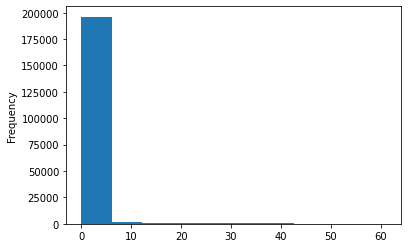

In [15]:
train["feature_0"].plot(kind="hist")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='feature_51', ylabel='Density'>

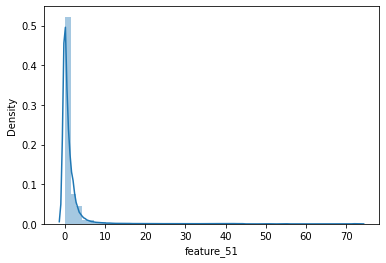

In [16]:
sns.distplot(train["feature_51"])

In [96]:
print( (train.drop("id",axis=1).min() != 0).sum() )
print("All the features have their lower bound set at 0.")

0
All the features have their lower bound set at 0.


In [107]:
train["feature_0"].value_counts()[:3]

0    146389
1     24536
2     10197
Name: feature_0, dtype: int64

In [103]:
# For getting any meaningful classification results, we'd need to somewhat "normalise" these distributions 
# before feeding them to any model.
# A naive "log" technique wont workout here because all features are bound by 0 at the bottom.
# We can pretend they're all some equal,very small value close to zero. say 10-k. and say log(that)=-k approx
# Alternatively, we can set log(feature) = -1 wherever it is 0 for continuity in the log distribution plot

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='feature_71', ylabel='Density'>

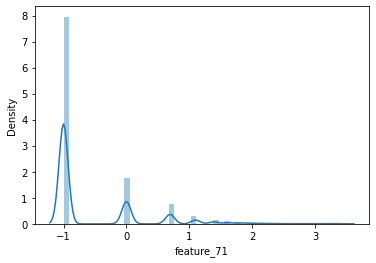

In [110]:
sns.distplot(train["feature_71"].apply(lambda x: np.log(x) if x>0 else -1))

In [141]:
counts_0123 = pd.DataFrame()
for feat in train.columns:
    counts_0123[feat] = train[feat].value_counts()[:4]

In [142]:
counts_0123

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
0,146389,140375,122501,120767,154093,119020,150969,150350,117000,124466,...,124517,165048,141642,145532,113213,132247,139966,123153,142555,169451
1,24536,27817,31503,33919,22750,39515,23209,25994,29111,34824,...,29468,15956,24523,26891,36147,35666,31300,34678,20573,16812
2,10197,11185,12208,12667,8039,19937,11020,11051,12811,18033,...,12192,7774,10112,12848,19770,13834,13342,17877,10100,6034
3,6651,5247,6136,7518,4364,6614,3731,4018,6792,4943,...,7936,3511,5623,5297,11528,5655,5352,8588,3980,2823


In [144]:
counts_0123.isna().sum().sum()   # all features have 0,1,2,3 occuring

0

In [147]:
print((counts_0123.loc[0]>counts_0123.loc[1]).sum(), (counts_0123.loc[1]>counts_0123.loc[2]).sum(), (counts_0123.loc[2]>counts_0123.loc[3]).sum())
print("Freq(0) > Freq(1) > Freq(2) > Freq(3) for all features")

75 75 75
Freq(0) > Freq(1) > Freq(2) > Freq(3) for all features


In [155]:
(counts_0123.sum()/train.shape[0]*100).describe()     # distr of (cummulative % of 0-4 bin)

count    75.000000
mean     90.428833
std       7.692485
min      58.905000
25%      88.905750
50%      92.148000
75%      95.232000
max      98.043500
dtype: float64

In [ ]:
corr_feats = train.corr()
# corr_feats

<AxesSubplot:>

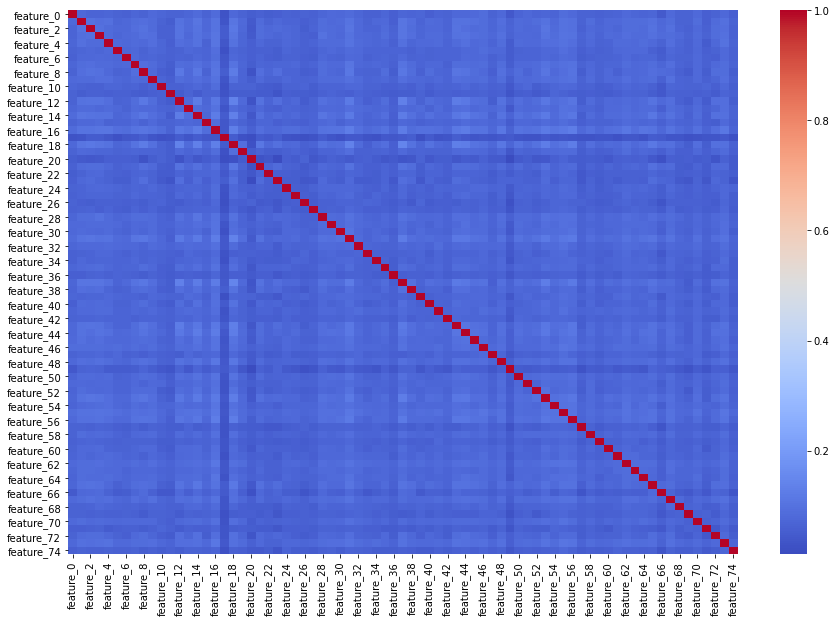

In [176]:
plt.figure(figsize=(15,10))
sns.heatmap(corr_feats, cmap="coolwarm")

In [179]:
corr_feats.describe().T

,count,mean,std,min,25%,50%,75%,max
feature_0,75.0,0.080236,0.108119,0.028813,0.062850,0.068937,0.075276,1.0
feature_1,75.0,0.092914,0.107215,0.032414,0.069606,0.083342,0.091038,1.0
feature_2,75.0,0.093287,0.107094,0.042984,0.071054,0.081452,0.089264,1.0
feature_3,75.0,0.094272,0.106891,0.045001,0.072966,0.082743,0.092168,1.0
feature_4,75.0,0.090327,0.107290,0.036713,0.070060,0.079835,0.085052,1.0
...,...,...,...,...,...,...,...,...
feature_70,75.0,0.087765,0.107397,0.028683,0.068283,0.078842,0.082448,1.0
feature_71,75.0,0.069407,0.109235,0.031733,0.051955,0.057053,0.062873,1.0
feature_72,75.0,0.082932,0.108315,0.033897,0.058601,0.070117,0.082785,1.0
feature_73,75.0,0.096160,0.106475,0.040226,0.077237,0.084954,0.092942,1.0


In [181]:
np.mean(corr_feats.describe().T["75%"])

0.08074181157054708

In [183]:
(corr_feats.describe().T["mean"]).describe()

count    75.000000
mean      0.084514
std       0.010653
min       0.048837
25%       0.077672
50%       0.085551
75%       0.092569
max       0.105867
Name: mean, dtype: float64

In [ ]:
# I have not bothered to remove the self-correlation factors of 1 along the diagonal
# But even with those values included, the mean correlation value for each pair of feature seems to be pretty low
# Add to that the std-dev of the of means is also low and the mean of means is only 0.08
# We can be pretty confident to say that features are not correlated. Also confirmed in our heatmap visually

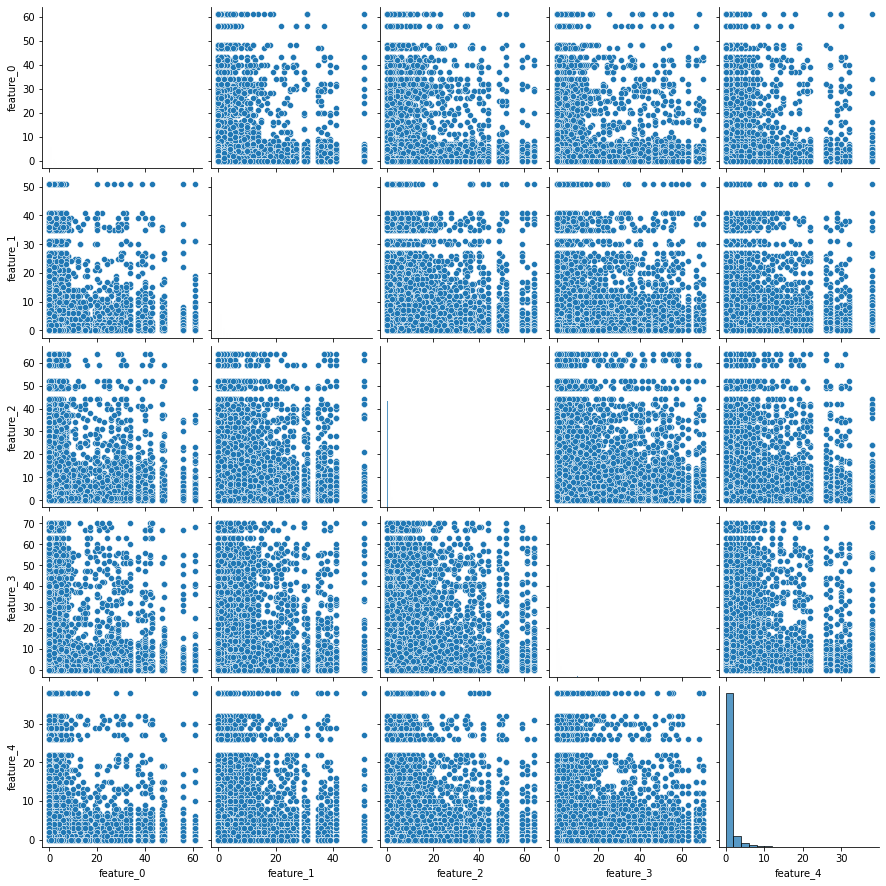

In [184]:
sns.pairplot(train[train.columns[:5]])

In [ ]:
# Pairplot of just the first 5 (beware, takes a while to process just this 5x5 grid) features shows how 
# uncorrelated these features are. That may be a good sign as far as multicollinearity is concerned.

## Feature Transformation

In [191]:
# Insight:
#  Since all the features are min-bounded by 0 and pretty much seem to have a geometric/exponential distribution,
#  we have to apply some transformation to "normalise" these feature and bring them closer to a normal distribution
#  before we feed these to a model of our choice

In [190]:
# For data that's >=0, we cant apply box-cox, we have to apply yeo-johnson transformation as below

In [17]:
shapiro(train["feature_2"])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.3719192147254944, pvalue=0.0)

#### Yeo-Jhonson transformer

In [18]:
yeojohn = PowerTransformer(method="yeo-johnson")

In [19]:
yeojohn.fit(train)

PowerTransformer()

In [20]:
transformed_train = yeojohn.transform(train)

In [21]:
transformed_train.shape

(200000, 75)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

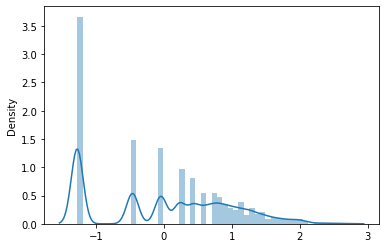

In [22]:
sns.distplot(transformed_train[:,19])

In [23]:
shapiro(transformed_train[:,19])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.914130687713623, pvalue=0.0)

In [24]:
how_normal = pd.DataFrame()
for i in range(transformed_train.shape[1]):
    how_normal["feature_"+str(i)] = shapiro(transformed_train[:,i])

In [25]:
how_normal.index = ["statistic", "p_value"]

In [26]:
how_normal

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
statistic,0.579727,0.615294,0.707144,0.715008,0.535863,0.714511,0.555397,0.554449,0.724228,0.696296,...,0.69484,0.46399,0.614032,0.58224,0.739304,0.653578,0.610456,0.695212,0.613291,0.432109
p_value,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [27]:
how_normal.loc["statistic"].describe()

count    75.000000
mean      0.653078
std       0.118851
min       0.411550
25%       0.564736
50%       0.646267
75%       0.724772
max       0.914131
Name: statistic, dtype: float64

In [28]:
print("p-value is uniformly 0 everywhere. It's not reliable for n>5000 as per doc and warning")
how_normal.loc["p_value"].describe()    # warnings: "p-value may not be accurate for N > 5000."

p-value is uniformly 0 everywhere. It's not reliable for n>5000 as per doc and warning


count    75.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: p_value, dtype: float64

#### Standard Scaler

In [29]:
scaler_std = StandardScaler()

In [30]:
scaler_std.fit(train)

StandardScaler()

In [31]:
std_scaled_train = scaler_std.transform(train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

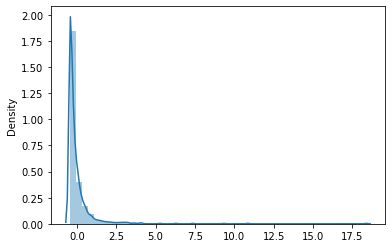

In [32]:
sns.distplot(std_scaled_train[:,19])

In [33]:
shapiro(std_scaled_train[:,19])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.3980720639228821, pvalue=0.0)

In [34]:
# Conclusion:

# Neither Yeo-Johnson, nor Standard Scaler is doing a good enough job in making out feature distributions 
# close to Normal curve

#### Box-Cox

In [ ]:
# Box-Cox strictly requires positive values to work with. 
# We can work around it be adding a small positive value uniformly

(<AxesSubplot:>, 0.31774)

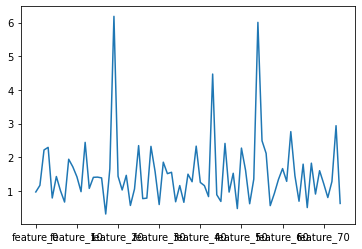

In [271]:
train.mean().plot(), train.mean().min()

(<AxesSubplot:>, 1.0526190348051674)

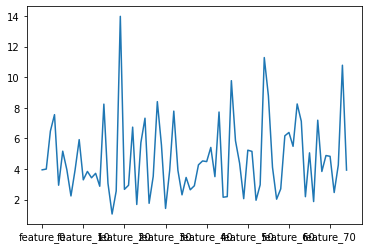

In [268]:
train.std().plot(), train.std().min()

In [348]:
boxcox = PowerTransformer(method="box-cox")
boxcox.fit(train+0.03)

PowerTransformer(method='box-cox')

In [349]:
boxcox_train = boxcox.transform(train+0.03)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='feature_19', ylabel='Density'>

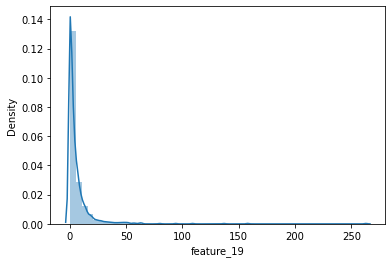

In [329]:
sns.distplot(train["feature_19"])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

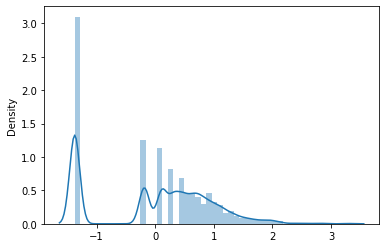

In [350]:
sns.distplot(boxcox_train[:,19])

In [354]:
normalizer = QuantileTransformer()
normalizer.fit(X_train)

QuantileTransformer()

In [355]:
normalised_train = normalizer.transform(X_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

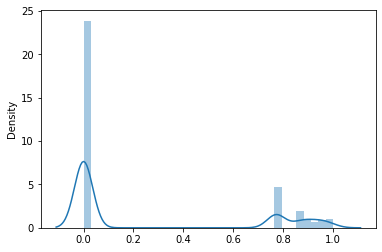

In [357]:
sns.distplot(normalised_train[:,1])

### Mirror of pre-processing to test data

In [35]:
test_ids = test.pop("id")      # You'll need to store the testdata id's for submission file. Normally you dont need

In [36]:
transformed_test = yeojohn.transform(test)

In [37]:
std_scaled_test = scaler_std.transform(test)

### Encoding Target Labels

In [38]:
targets.value_counts()

Class_6    51811
Class_8    51763
Class_9    25542
Class_2    24431
Class_3    14798
Class_7    14769
Class_1     9118
Class_4     4704
Class_5     3064
Name: target, dtype: int64

In [39]:
targets.nunique(), np.sort(targets.unique())

(9,
 array(['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
        'Class_7', 'Class_8', 'Class_9'], dtype=object))

In [40]:
lab_encoder = LabelEncoder()

In [41]:
lab_encoder.fit(targets)

LabelEncoder()

In [42]:
targets = pd.Series(lab_encoder.transform(targets), name=targets.name)

In [43]:
targets.value_counts()

5    51811
7    51763
8    25542
1    24431
2    14798
6    14769
0     9118
3     4704
4     3064
Name: target, dtype: int64

In [44]:
lab_encoder.inverse_transform(targets)

array(['Class_6', 'Class_6', 'Class_2', ..., 'Class_8', 'Class_7',
       'Class_8'], dtype=object)

# Setup for Cross-Validation

In [45]:
test_fraction = 0.3
rand_state    = 2003

In [46]:
X,y = train, targets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_fraction, random_state=rand_state)

In [47]:
X_train.shape, X_test.shape

((140000, 75), (60000, 75))

In [48]:

X_train_yeo, X_test_yeo = train_test_split(transformed_train, test_size=test_fraction, random_state=rand_state)


In [49]:

X_train_stdscale, X_test_stdscale = train_test_split(std_scaled_train, test_size=test_fraction, random_state=rand_state)


In [50]:
X_train_stdscale.shape, X_test_stdscale.shape

((140000, 75), (60000, 75))

### Kaggle Metric Setup

In [ ]:
# use sklearn.metrics.log_loss 

In [653]:
# log_reg.predict_proba(X_train.iloc[1:2,])[0,[y_train.iloc[1]]]

def kaggle_score(y_true, y_pred):
    y_true_to_use = y_true
    if "Series" in str(type(y_true)):
        y_true_to_use = y_true.values
    tot = 0
    for i in range(y_true_to_use.shape[0]):
        curlog = y_pred[i,y_true_to_use[i]]
#         curlog = np.max( np.min( curlog ,1- 10e-15), 10e-15)
        tot -= curlog
    return tot/y_true_to_use.shape[0]

In [660]:
def log_of_probabilities(arr):
    og_shape = arr.shape
    MAX_LIMIT = 1-1e-15
    MIN_LIMIT = 1e-15
    temp = arr.reshape(-1)
    temp = np.where(temp<(MAX_LIMIT), temp, MAX_LIMIT)
    temp = np.log(np.where(temp>(MIN_LIMIT), temp, MIN_LIMIT))
    return temp.reshape(og_shape)

In [52]:
# Q] What's the minimum performance i should expect out of my learning model?

# A] One could naively give equal probability to all class for each test observation, i.e guess the class with
#     no learning effort involved. That should give a log-loss value of:
    
#                         -np.log(1/9) = 2.1972

# Infer]: 
#     Our models should have a log-loss value lower than that to perform better than a no-learning human guess

In [53]:
-np.log2(1/9), -np.log(1/9)

(3.1699250014423126, 2.1972245773362196)

# Basic Modelling

## 1. Logistic Regression

In [55]:
log_reg = LogisticRegression(max_iter=2000, multi_class="ovr")

In [56]:
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=2000, multi_class='ovr')

In [57]:
log_reg.score(X_train, y_train)*100

34.010714285714286

In [58]:
log_reg.score(X_test, y_test)*100

33.75

In [369]:
log_reg_full = LogisticRegression(max_iter=2000, multi_class="ovr").fit(train,targets)
log_reg_full.score(train,targets), kaggle_score(targets, log_reg_full.predict_log_proba(train))

(0.339595, 1.8259828096746378)

In [370]:
log_reg_full_yeo = LogisticRegression(max_iter=2000, multi_class="ovr").fit(transformed_train,targets)
log_reg_full_yeo.score(transformed_train,targets), kaggle_score(targets, log_reg_full_yeo.predict_log_proba(transformed_train))

(0.360805, 1.758523070263844)

In [508]:
log_reg_full_yeo.n_iter_

array([15, 15, 17, 17, 19, 11, 13, 13, 13], dtype=int32)

In [59]:
log_reg_yeo = LogisticRegression(max_iter=2000, multi_class="ovr")
log_reg_yeo.fit(X_train_yeo, y_train)

LogisticRegression(max_iter=2000, multi_class='ovr')

In [60]:
log_reg_yeo.score(X_train_yeo, y_train)*100

36.083571428571425

In [61]:
log_reg_yeo.score(X_test_yeo, y_test)*100

35.91666666666667

In [62]:
log_reg_stdscale = LogisticRegression(max_iter=2000, multi_class="ovr")
log_reg_stdscale.fit(X_train_stdscale, y_train)

LogisticRegression(max_iter=2000, multi_class='ovr')

In [63]:
log_reg_stdscale.score(X_train_stdscale, y_train)*100

34.01

In [64]:
log_reg_stdscale.score(X_test_stdscale, y_test)*100

33.75

In [65]:
print( "Kaggle scores would be = ", kaggle_score(y_train.values, log_reg.predict_log_proba(X_train)),",",
      kaggle_score(y_test.values, log_reg.predict_log_proba(X_test)) )

Kaggle scores would be =  1.8246249784065909 , 1.8316102699630656


In [66]:
print( "Kaggle scores would be = ", kaggle_score(y_train.values, log_reg_yeo.predict_log_proba(X_train_yeo)),",",
      kaggle_score(y_test.values, log_reg_yeo.predict_log_proba(X_test_yeo)) )

Kaggle scores would be =  1.7577763569525238 , 1.7624046913491402


In [67]:
# In terms of Kaggle Leaderboard as of 23-Jun-2021, 11pm:
#     Untransformed Variables : 830
#     Yeo-Johnson best rank   : 658
# That's a good enough rank improvement for a mere transformation of the features, without any change to model.
# Now onto model experimentation

## 2. Naive Bayes Classifier

In [68]:
gaussNB = GaussianNB()
gaussNB.fit(X_train,y_train)
print("GaussNB Scores without transformations")
gaussNB.score(X_train, y_train)*100, gaussNB.score(X_test, y_test)*100

GaussNB Scores without transformations


(17.599999999999998, 17.083333333333332)

In [69]:
print( "Kaggle scores would be = ", kaggle_score(y_train.values, gaussNB.predict_log_proba(X_train)),",",
      kaggle_score(y_test.values, gaussNB.predict_log_proba(X_test)) )

Kaggle scores would be =  15.122857704619198 , 15.246021967405449


In [71]:
gaussNB_yeo = GaussianNB()
gaussNB_yeo.fit(X_train_yeo,y_train)
print("GaussNB Scores with Yeo-Johnson transformations")
gaussNB_yeo.score(X_train_yeo, y_train)*100, gaussNB_yeo.score(X_test_yeo, y_test)*100

GaussNB Scores with Yeo-Johnson transformations


(31.965, 32.211666666666666)

In [72]:
print( "Kaggle scores would be = ", kaggle_score(y_train.values, gaussNB_yeo.predict_log_proba(X_train_yeo)),",",
      kaggle_score(y_test.values, gaussNB_yeo.predict_log_proba(X_test_yeo)) )

Kaggle scores would be =  5.301361177079673 , 5.262120811752523


In [73]:
# gaussNB_stdscale = GaussianNB()
# gaussNB_stdscale.fit(X_train_stdscale,y_train)
# print("GaussNB Scores with Standard Scaler")
# gaussNB_stdscale.score(X_train_stdscale, y_train)*100, gaussNB_stdscale.score(X_test_stdscale, y_test)*100

In [74]:
%precision 2
np.set_printoptions(precision=4, suppress=True)
gaussNB.predict_proba(X_train)[:3]

array([[0.    , 0.9999, 0.0001, 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    ],
       [0.    , 0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.    ,
        0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.0003, 0.    , 0.0567, 0.9416,
        0.0013]])

In [75]:
log_reg.predict_proba(X_train)[:3]

array([[0.0444, 0.202 , 0.1045, 0.0225, 0.0146, 0.2155, 0.0597, 0.1987,
        0.138 ],
       [0.0444, 0.0162, 0.0225, 0.0178, 0.0348, 0.1114, 0.1236, 0.4837,
        0.1456],
       [0.049 , 0.0587, 0.0471, 0.0219, 0.0155, 0.2241, 0.0882, 0.3302,
        0.1652]])

In [76]:
# Conclusions;
#     GaussianNB is not at all suitable. It is producing probability(class) array that is too skewed, i.e
#     either extremes : too close to 0 or too close to 1.
#     Consequently our log(prob) involved in the log-loss formula is getting large negative values, increasing
#     our overall log-loss score.
    
# Diagnosis:
#     So why isnt GaussNB not working well.
#     It was to be expected because our best transformation so far, the Yeo-Johnson, did not achieve 
#     convincing levels of "normalisation" in the first place. It failed Shapiro test pretty much everywhere.
#     GaussNB should perform much better if we can eliminate the severe non-normal skew.

## 3. Multinomial Naive Bayes

In [512]:
def evaluator(model, X_fit, y_fit, X_val, y_val):
    mnb = model.fit(X_fit,y_fit)
    print("Accuracies for train and test:")
    print("\t", mnb.score(X_fit, y_fit)*100,",", mnb.score(X_val, y_val)*100 )
    print("Kaggle scores for train and test")
    print("\t", kaggle_score(y_fit.values,mnb.predict_log_proba(X_fit)),",",
            kaggle_score(y_val.values,mnb.predict_log_proba(X_val)) )
    
    return model

In [509]:
untransformed = (X_train, y_train, X_test, y_test)
mnb_untrans = evaluator(MultinomialNB(), *untransformed)

Accuracies for train and test:
	 26.781428571428574 , 26.463333333333335
Kaggle scores for train and test
	 4.729132212984831 , 4.811764797622004


In [511]:
yeotransformed = (X_train_yeo, y_train, X_test_yeo, y_test)
mnb_yeo = evaluator(MultinomialNB(), *yeotransformed)

ValueError: Negative values in data passed to MultinomialNB (input X)

## 3. kNN classifier

In [77]:
kn = KNeighborsClassifier(50)
kn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=50)

In [81]:
kn.score(X_train[:1000], y_train[:1000])
# kn.score(X_test[:1000], y_test[:1000])

0.336

In [661]:
kaggle_score( y_test[:2000].values,
              log_of_probabilities(kn.predict_proba(X_test[:2000])) ) 

2.6789944693913084

In [ ]:
# Remember that it's better to pass an odd-number for k in KNN classifier to avoid tie-situations

## 4. Decision Tree Classifiers

In [192]:
n_max_depth = 10
tree_results = pd.DataFrame()
scores, kaggles = [], []
for i in range(1,n_max_depth+1):
    dtree = DecisionTreeClassifier(max_depth=i).fit(X_train, y_train)
    scores.append((dtree.score(X_train, y_train), dtree.score(X_test, y_test)))
    kaggles.append( (kaggle_score(y_train, log_of_probabilities(dtree.predict_proba(X_train)) ), 
                    kaggle_score(y_test, log_of_probabilities(dtree.predict_proba(X_test)) ) )
                  )


In [195]:
tree_results = pd.concat([pd.DataFrame(scores,  columns=["score_train", "score_test"]), 
                          pd.DataFrame(kaggles, columns=["logloss_train", "logloss_test"])],axis=1)
tree_results.index = list(range(1,n_max_depth+1))

In [199]:
tree_results

,score_train,score_test,logloss_train,logloss_test
1,0.276164,0.275967,1.859066,1.860514
2,0.317779,0.317667,1.843888,1.846411
3,0.322371,0.320933,1.827658,1.831971
4,0.325214,0.323533,1.814750,1.819013
5,0.330307,0.324950,1.805315,1.811894
6,0.339336,0.332733,1.796928,1.806436
7,0.344879,0.334100,1.786752,1.812564
8,0.351200,0.334750,1.773806,1.853491
9,0.361414,0.334667,1.754679,1.967182
10,0.372736,0.332350,1.725377,2.219584


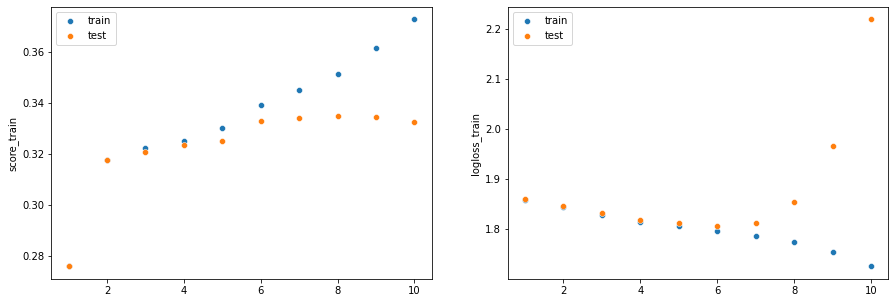

In [213]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.scatterplot(data=tree_results, x=tree_results.index, y="score_train", label="train")
sns.scatterplot(data=tree_results, x=tree_results.index, y="score_test", label="test")
plt.legend()

plt.subplot(1,2,2)
sns.scatterplot(data=tree_results, x=tree_results.index, y="logloss_train", label="train")
sns.scatterplot(data=tree_results, x=tree_results.index, y="logloss_test", label="test")
plt.legend()

In [214]:
# These plots above demonstrate the classic case of bias-variance trade-off.
# the optimal depth of our single tree depends on which optimisation parameter we are interested in
# if we go for accuracy, optimal might be 8,
# if we want to reduce the logloss for kaggle score, optimal might be just 6

## 5. Random Forest

In [263]:
rand_forest = RandomForestClassifier(n_estimators=400, max_depth=4, max_features=4, random_state=2003)

In [248]:
np.sqrt((train.shape[1])) , train.shape[1]/3

(8.660254037844387, 25.00)

In [259]:
rand_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features=4, n_estimators=400)

In [260]:
rand_forest.score(X_train, y_train), rand_forest.score(X_test, y_test)

(0.35954285714285716, 0.35906666666666665)

In [261]:
kaggle_score( y_train, log_of_probabilities(rand_forest.predict_proba(X_train)) )

1.80114847178468

In [262]:
kaggle_score( y_test, log_of_probabilities(rand_forest.predict_proba(X_test)) )

1.803734778777658

In [ ]:
# Transformation of features does not matter here, largely. So skipping the use of yeo-johnson set.

In [408]:
rand_forest_full = RandomForestClassifier(n_estimators=500, max_depth=4, max_features=4, random_state=2003).fit(train, targets)
print(rand_forest_full.score(train, targets), 
        kaggle_score( targets, log_of_probabilities(rand_forest_full.predict_proba(train)) ) )


0.3605 1.8015089797688697


## 6. SVM

In [299]:
svc = LinearSVC()
svc.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC()

In [300]:
svc.score(X_train, y_train)

0.30947857142857144

In [301]:
svc.score(X_test, y_test)

0.30788333333333334

In [358]:
svc.predict(X_train)

array([1, 7, 1, ..., 2, 7, 1])

## 7. PCA (for reducing parameter space. avoiding "curse of dimensionality")

In [427]:
pca = PCA().fit(train)

In [437]:
pca.explained_variance_ratio_

array([0.1167, 0.0759, 0.0531, 0.0457, 0.0386, 0.0318, 0.0301, 0.0293,
       0.0277, 0.0263, 0.0248, 0.0241, 0.023 , 0.0219, 0.0206, 0.019 ,
       0.018 , 0.0172, 0.0161, 0.0152, 0.0146, 0.0139, 0.0133, 0.0128,
       0.0123, 0.0118, 0.0116, 0.0112, 0.0107, 0.0103, 0.0093, 0.009 ,
       0.0085, 0.0081, 0.0079, 0.0075, 0.0072, 0.0069, 0.0069, 0.0069,
       0.0068, 0.0067, 0.0066, 0.0065, 0.0064, 0.006 , 0.0056, 0.0054,
       0.0052, 0.005 , 0.0048, 0.0041, 0.0038, 0.0037, 0.0037, 0.0035,
       0.0034, 0.0033, 0.0032, 0.0031, 0.0027, 0.0027, 0.0024, 0.0022,
       0.0021, 0.0021, 0.002 , 0.0019, 0.0018, 0.0017, 0.0016, 0.0014,
       0.0012, 0.0009, 0.0005])

In [442]:
np.cumsum(pca.explained_variance_ratio_)

array([0.1167, 0.1926, 0.2457, 0.2914, 0.33  , 0.3619, 0.392 , 0.4214,
       0.449 , 0.4753, 0.5001, 0.5241, 0.5472, 0.5691, 0.5897, 0.6087,
       0.6267, 0.6438, 0.66  , 0.6751, 0.6897, 0.7036, 0.7169, 0.7297,
       0.742 , 0.7538, 0.7655, 0.7767, 0.7874, 0.7977, 0.807 , 0.816 ,
       0.8246, 0.8327, 0.8406, 0.8481, 0.8553, 0.8622, 0.8691, 0.8759,
       0.8827, 0.8894, 0.896 , 0.9025, 0.9089, 0.9149, 0.9204, 0.9259,
       0.9311, 0.9362, 0.941 , 0.9451, 0.9489, 0.9527, 0.9563, 0.9599,
       0.9633, 0.9666, 0.9698, 0.9729, 0.9756, 0.9783, 0.9807, 0.9829,
       0.985 , 0.987 , 0.989 , 0.9909, 0.9927, 0.9944, 0.996 , 0.9974,
       0.9986, 0.9995, 1.    ])

In [ ]:
# Desired properties of pca are not turning up for this dataset.
# The variance between observations is being contributed incrementally by quite a lot of factors.
# It takes __ of 75 parameters to explain __ variance
    53 -> 95%
    62 -> 98%
    67 -> 99%

## 8. KMeans to see if clusters help

In [597]:
kmn = KMeans(n_clusters=9).fit(transformed_train)

In [604]:
pd.DataFrame(kmn.labels_).value_counts()

5    34769
3    29731
8    28256
6    24410
1    23518
2    17680
0    17628
4    13131
7    10877
dtype: int64

In [603]:
targets.value_counts()

5    51811
7    51763
8    25542
1    24431
2    14798
6    14769
0     9118
3     4704
4     3064
Name: target, dtype: int64

In [599]:
micromod_res = []
model_seq = []
for i in range(9):
    selection = kmn.labels_==i
    mock_logreg = LogisticRegression(max_iter=2000).fit(transformed_train[selection], targets[selection])
    
    micromod_res.append( (i,
                          mock_logreg.score(transformed_train[selection], targets[selection]), 
                          kaggle_score(targets[selection], mock_logreg.predict_log_proba(transformed_train[selection]))
                         )  )
    model_seq.append(mock_logreg)

In [600]:
micromod_res = pd.DataFrame(micromod_res, columns=["kmean_cluster", "score", "logloss" ])
micromod_res

,kmean_cluster,score,logloss
0,0,0.375993,1.815256
1,1,0.273493,1.909208
2,2,0.391290,1.693604
3,3,0.325418,1.790339
4,4,0.686696,1.031367
5,5,0.328051,1.841576
6,6,0.390004,1.620132
7,7,0.377494,1.656397
8,8,0.331505,1.815074


In [601]:
np.sum([(kmn.labels_==i).sum() * micromod_res.loc[i,"logloss"] for i in range(9)])/transformed_train.shape[0]

1.73247496337004

In [602]:
micromod_res["logloss"].mean()

1.6858836700916362

In [523]:
micromod_res     # KMeans+log_reg fit on untransformed train dataset (huge skew in nums distributed across clusters)

,kmean_cluster,score,logloss
0,0,0.346895,1.801780
1,1,0.357391,1.738503
2,2,0.320819,1.787238
3,3,0.340920,1.756500
4,4,0.350462,1.765826
5,5,0.338294,1.784044
6,6,0.366047,1.705605
7,7,0.588561,1.101036
8,8,0.356779,1.772203


In [607]:
test_cluster_id = kmn.predict(transformed_test)
test_cluster_id

array([5, 3, 4, ..., 5, 7, 8], dtype=int32)

In [609]:
test_probas = np.array([ model_seq[test_cluster_id[i]].predict_proba(transformed_test[i:i+1]) for i in range(transformed_test.shape[0]) ]).reshape((-1,9))
test_probas

array([[0.0732, 0.3893, 0.1668, ..., 0.0239, 0.0471, 0.1117],
       [0.0282, 0.0595, 0.0449, ..., 0.0922, 0.3208, 0.1279],
       [0.0158, 0.0261, 0.0158, ..., 0.038 , 0.1007, 0.0525],
       ...,
       [0.0798, 0.311 , 0.1159, ..., 0.039 , 0.0954, 0.1577],
       [0.0454, 0.0433, 0.0197, ..., 0.071 , 0.2771, 0.0931],
       [0.0479, 0.0884, 0.076 , ..., 0.0587, 0.2257, 0.1483]])

In [610]:
test_probas.shape

(100000, 9)

In [611]:
filename = "./submissions/4_micromodelled_logreg.csv"
result_4 = pd.concat([test_ids, pd.DataFrame(test_probas)], axis=1)
result_4.columns = submission_header
result_4.to_csv(filename, index=False, header=True)
result_4

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,200000,0.073213,0.389301,0.166757,0.026022,0.011916,0.150108,0.023852,0.047126,0.111707
1,200001,0.028241,0.059459,0.044861,0.026389,0.017421,0.282743,0.092231,0.320793,0.127861
2,200002,0.015796,0.026148,0.015834,0.010859,0.001376,0.738839,0.037981,0.100687,0.052481
3,200003,0.044839,0.073739,0.073431,0.036838,0.030197,0.230944,0.089417,0.256741,0.163855
4,200004,0.036442,0.077088,0.078786,0.008876,0.002959,0.330005,0.055066,0.287053,0.123723
...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.110504,0.360763,0.130359,0.032648,0.011858,0.091836,0.036549,0.072099,0.153384
99996,299996,0.043803,0.260997,0.125339,0.014315,0.005379,0.174805,0.037072,0.186836,0.151454
99997,299997,0.079801,0.311000,0.115936,0.029717,0.004482,0.166998,0.038962,0.095372,0.157732
99998,299998,0.045437,0.043280,0.019698,0.011911,0.006720,0.431647,0.071034,0.277126,0.093148


In [620]:
# The above submission scored 1.76605 with no change to ranking

In [ ]:
# Lets run a Cross-Validation comparison on the improvements seen above on the full dataset

In [547]:
kmn = KMeans(n_clusters=9).fit(X_train_yeo)
pd.DataFrame(kmn.labels_).value_counts()

0    24532
4    20947
7    19951
1    17038
5    16362
8    12394
3    12062
2     9221
6     7493
dtype: int64

In [572]:
micromod_res = []
model_seq = []
for i in range(9):
    selection = kmn.labels_==i
    mock_logreg = LogisticRegression(max_iter=2000).fit(X_train_yeo[selection], y_train.iloc[selection])
    
    micromod_res.append( (i,
                          mock_logreg.score(X_train_yeo[selection], y_train.iloc[selection]), 
                          kaggle_score(y_train.iloc[selection], mock_logreg.predict_log_proba(X_train_yeo[selection]))
                         )  )
    model_seq.append(mock_logreg)

In [573]:
micromod_res = pd.DataFrame(micromod_res, columns=["kmean_cluster", "score", "logloss" ])
micromod_res

,kmean_cluster,score,logloss
0,0,0.329121,1.835525
1,1,0.386959,1.620290
2,2,0.683006,1.027578
3,3,0.392638,1.690446
4,4,0.327971,1.784274
5,5,0.282423,1.898595
6,6,0.379688,1.637245
7,7,0.332414,1.808833
8,8,0.374375,1.812005


In [574]:
print("Training weighted logloss is ")
np.sum([(kmn.labels_==i).sum() * micromod_res.loc[i,"logloss"] for i in range(9)])/X_train_yeo.shape[0]

Training weighted logloss is 


1.7268208676603904

In [588]:
micromod_res["logloss"].mean()

1.6794210070221594

In [577]:
test_cluster_id = kmn.predict(X_test_yeo)
test_cluster_id

array([5, 0, 7, ..., 8, 5, 3], dtype=int32)

In [589]:
test_probas = np.array([ model_seq[test_cluster_id[i]].predict_proba(X_test_yeo[i:i+1]) for i in range(X_test_yeo.shape[0]) ]).reshape((-1,9))
test_probas

array([[0.0371, 0.2804, 0.1498, ..., 0.0944, 0.2078, 0.1488],
       [0.0791, 0.4854, 0.1579, ..., 0.019 , 0.0329, 0.101 ],
       [0.0295, 0.1327, 0.13  , ..., 0.0392, 0.1806, 0.1617],
       ...,
       [0.0657, 0.0819, 0.0404, ..., 0.1053, 0.5205, 0.1042],
       [0.0241, 0.2136, 0.1127, ..., 0.0798, 0.3931, 0.1151],
       [0.0501, 0.0265, 0.0149, ..., 0.1317, 0.4297, 0.1031]])

In [591]:
print("Validation weighted logloss is ")
kaggle_score(y_test, log_of_probabilities(test_probas))

Validation weighted logloss is 


1.765774234639983

## 9. XGBoost - The beast unleashed

In [ ]:
# 1. CV on untransformed data (really shouldnt matter much for boosting of decision trees anyway. but lets check)

In [622]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_test  = xgb.DMatrix(X_test, label=y_test)

In [629]:
xg_params = {
            'eta':0.2,
            'max_depth': 4,
            'objective':'multi:softprob',
            'num_class':9
            }
steps = 25

In [630]:
xgb_model = xgb.train(xg_params, d_train,steps)

In [636]:
accuracy_score(y_train, np.array([np.argmax(line) for line in xgb_model.predict(d_train)]))

0.36597857142857143

In [637]:
accuracy_score(y_test, np.array([np.argmax(line) for line in xgb_model.predict(d_test)]))

0.35883333333333334

In [654]:
kaggle_score(y_train, log_of_probabilities(xgb_model.predict(d_train)))

1.7398303690450532

In [639]:
kaggle_score(y_test, log_of_probabilities(xgb_model.predict(d_test)))

1.7617290721883376

In [ ]:
# 2. CV on transformed data

In [640]:
d_train = xgb.DMatrix(X_train_yeo, label=y_train)
d_test  = xgb.DMatrix(X_test_yeo, label=y_test)

In [641]:
xg_params = {
            'eta':0.2,
            'max_depth': 4,
            'objective':'multi:softprob',
            'num_class':9
            }
steps = 25

In [642]:
xgb_model = xgb.train(xg_params, d_train,steps)

In [643]:
accuracy_score(y_train, np.array([np.argmax(line) for line in xgb_model.predict(d_train)]))

0.3657142857142857

In [644]:
accuracy_score(y_test, np.array([np.argmax(line) for line in xgb_model.predict(d_test)]))

0.35956666666666665

In [645]:
kaggle_score(y_train, log_of_probabilities(xgb_model.predict(d_train)))

1.7398303690450532

In [646]:
kaggle_score(y_test, log_of_probabilities(xgb_model.predict(d_test)))

1.7616406502105295

In [ ]:
# conclusion.
# XGBoost improves accuracy and logloss marginally. A GridSeach could deliver better paramset for xgboost
# Or we could combine with our micromodelling approach also

In [647]:
d_test_res = xgb.DMatrix(transformed_test)

In [651]:
filename = "./submissions/5_unopt_xgboost.csv"
result_5 = pd.concat([test_ids, pd.DataFrame(xgb_model.predict(d_test_res))], axis=1)
result_5.columns = submission_header
result_5.to_csv(filename, index=False, header=True)
result_5

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,200000,0.051113,0.342867,0.154381,0.027888,0.016650,0.184387,0.034274,0.072327,0.116113
1,200001,0.041906,0.123609,0.087936,0.024753,0.018623,0.241702,0.073636,0.274175,0.113659
2,200002,0.039452,0.046064,0.035331,0.024868,0.016830,0.542055,0.046209,0.166091,0.083100
3,200003,0.059951,0.115269,0.083549,0.039025,0.025500,0.240815,0.073603,0.202784,0.159504
4,200004,0.042556,0.119303,0.071883,0.033338,0.018904,0.336896,0.062891,0.183090,0.131139
...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.060304,0.372107,0.138665,0.029277,0.018485,0.113531,0.045510,0.096491,0.125631
99996,299996,0.051443,0.273182,0.098102,0.025053,0.018432,0.232147,0.045463,0.132728,0.123448
99997,299997,0.071786,0.239312,0.128563,0.033710,0.021287,0.145369,0.056534,0.157507,0.145934
99998,299998,0.037356,0.034097,0.032831,0.020150,0.017763,0.383054,0.068499,0.324938,0.081313


In [ ]:
# The above submission gave a score of 1.76394 and an improvement in ranking (now 752)

## [Final] Ensemble of Models

In [445]:
ensemble_1 = VotingClassifier()

In [447]:
VotingClassifier?

## 10. Logreg confidence analysis

In [666]:
logmod = log_reg_full_yeo

In [668]:
logmod.score(transformed_train,targets)

0.360805

In [691]:
logmod.predict(transformed_train)[:10]

array([5, 5, 7, 7, 1, 7, 5, 7, 7, 1])

In [708]:
np.max(logmod.decision_function(transformed_train), axis=1)[cor_index]

array([ 1.2272, -0.5419, -0.564 , ..., -0.8508, -0.6396, -0.3255])

In [683]:
cor_index = logmod.predict(transformed_train) == targets

In [688]:
pd.DataFrame(logmod.predict_proba(transformed_train)).loc[cor_index]

,0,1,2,3,4,5,6,7,8
0,0.026148,0.022840,0.021901,0.009758,0.006309,0.663351,0.039023,0.156389,0.054282
1,0.040073,0.189108,0.083674,0.025309,0.011265,0.373925,0.040531,0.125512,0.110603
3,0.054000,0.090872,0.098006,0.024464,0.026556,0.077800,0.106649,0.351373,0.170281
4,0.047198,0.274206,0.127545,0.021608,0.015235,0.168359,0.043874,0.149669,0.152307
5,0.057384,0.239739,0.095739,0.035856,0.016274,0.062760,0.067176,0.268537,0.156534
...,...,...,...,...,...,...,...,...,...
199992,0.031127,0.027833,0.026692,0.014140,0.010146,0.327103,0.078583,0.391640,0.092736
199994,0.027156,0.008143,0.014441,0.010826,0.012902,0.333443,0.107351,0.406493,0.079246
199996,0.035195,0.087039,0.065335,0.020633,0.012385,0.314862,0.062848,0.262597,0.139106
199997,0.033527,0.027526,0.040873,0.014746,0.021398,0.256611,0.088346,0.370605,0.146369


In [702]:
dec_for_correct = np.max(logmod.decision_function(transformed_train), axis=1)[cor_index]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

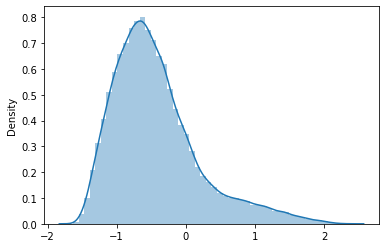

In [703]:
sns.distplot(dec_for_correct)

In [709]:
dec_for_INcorrect = np.max(logmod.decision_function(transformed_train), axis=1)[~cor_index]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

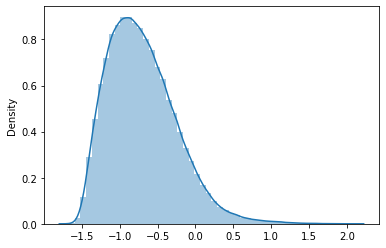

In [710]:
sns.distplot(dec_for_INcorrect)

In [716]:
declens = logmod.decision_function(transformed_train)
declens

array([[-3.4596, -3.5989, -3.642 , ..., -3.0436, -1.5007, -2.6948],
       [-3.1935, -1.4763, -2.4116, ..., -3.1817, -1.9603, -2.1033],
       [-2.9072, -2.0795, -2.736 , ..., -2.3915, -0.9986, -1.8495],
       ...,
       [-3.4343, -3.6373, -3.2291, ..., -2.4112, -0.6396, -1.8456],
       [-2.8183, -2.02  , -2.36  , ..., -2.9101, -1.5403, -1.8347],
       [-3.1213, -3.8112, -3.9838, ..., -2.4291, -0.3255, -2.4115]])

In [869]:
result_tr = logmod.predict_proba(transformed_train)

In [870]:
kaggle_score(targets, log_of_probabilities(result_tr))     # BASELINE RESULT

1.758523070263844

In [906]:
correctable_index = np.where(np.max(declens, axis=1)>=1.1)[0]
# correctable_index

Min achieved = 1.7580046896258075
      0         1
0  0.95  1.758354
1  0.90  1.758005
2  0.85  1.758114
3  0.80  1.758437
4  0.75  1.758903
5  0.70  1.759483
6  0.65  1.760167
7  0.60  1.760954
8  0.55  1.761849
9  0.50  1.762864


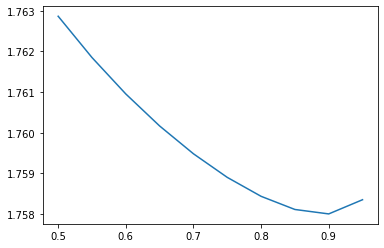

In [907]:
# THRESH = 0.9
thresult = []
for THRESH in np.arange(0.95,0.45,-0.05):
    result_tr = logmod.predict_proba(transformed_train)
    for ind in correctable_index:
        atmax = np.argmax(result_tr[ind])
        result_tr[ind] = np.ones(9)*(1-THRESH)/8
        result_tr[ind,atmax] = THRESH
    thresult.append( (THRESH, kaggle_score(targets, log_of_probabilities(result_tr))) )
thresult = pd.DataFrame(thresult)
print("Min achieved =", thresult[1].min())
print(thresult)
plt.plot(thresult[0],thresult[1])

In [914]:
result_tr = logmod.predict_proba(transformed_train)

In [918]:
sorted_res = np.sort(result_tr,axis=1)[:,::-1]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

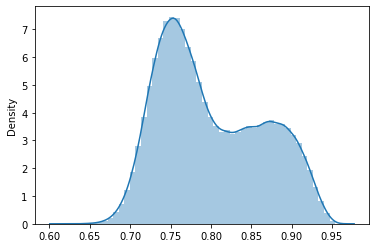

In [927]:
sns.distplot(sorted_res[:,:4].sum(axis=1))

## Q] Are my features categorical in nature?

In [953]:
a = np.sort(train["feature_2"].unique())
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34,
       35, 36, 37, 38, 40, 41, 42, 44, 49, 50, 52, 59, 61, 64])

In [952]:
b = np.sort(test["feature_2"].unique())
b

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34,
       35, 36, 37, 38, 40, 41, 42, 44, 49, 50, 52, 59, 61, 64])

In [960]:
feat_subs = []
for feat in train.columns:
    trainset = set(train[feat].unique())
    testset  = set(test[feat].unique())
    if not trainset.issuperset(testset):
        print(feat)

feature_59
feature_60


In [974]:
ax = np.sort(train["feature_59"].unique())
unseens = []
for xx in np.sort(test["feature_59"].unique()):
    if xx not in ax:
        unseens.append(xx)
unseens

[62, 69, 88, 110, 112, 119, 139, 165, 170, 181, 283, 323]

In [969]:
ax = np.sort(train["feature_60"].unique())
for xx in np.sort(test["feature_60"].unique()):
    if xx not in ax:
        print(xx)

105


In [973]:
test[test["feature_60"] == 105]

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
39760,0,3,0,1,30,0,11,1,2,5,...,0,4,0,2,1,0,0,0,0,0
61228,0,27,0,5,0,1,0,18,11,2,...,0,15,0,1,0,6,1,1,22,0


In [976]:
test["feature_59"].apply(lambda x: 1 if x in unseens else 0).sum()

16

In [ ]:
# Only 2 features have values in test not present in training set.
# Also there is a total of 2+16=18 such occurences where feat-59,60 both combined have these new values in test

In [982]:
combinedset = pd.concat([train,test],axis=0)
unqs = pd.Series([0]*len(train.columns), index=train.columns)
for feat in train.columns:
    unqs[feat] = combinedset[feat].nunique()

In [983]:
unqs

feature_0     42
feature_1     37
feature_2     48
feature_3     59
feature_4     30
              ..
feature_70    49
feature_71    31
feature_72    37
feature_73    91
feature_74    50
Length: 75, dtype: int64

In [984]:
unqs.sum()

3359

In [994]:
molten = pd.melt(train)
print(molten.nunique())
print(molten.max())

variable     75
value       142
dtype: int64
variable    feature_9
value             352
dtype: object


In [999]:
molten = pd.melt(combinedset)
print(molten.nunique())
print(molten.max())

variable     75
value       148
dtype: int64
variable    feature_9
value             352
dtype: object


In [997]:
train.max().max(), test.max().max()

(352, 352)

In [998]:
train.min().min(), test.min().min()

(0, 0)

In [ ]:
# We can treat these variable as being categorical in nature and being filled from 0 to 352.
# So in a neural network we can perhaps map them into a lower dimensional vector using an Embedding Layer

In [990]:
train.drop_duplicates()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
0,0,0,6,1,0,0,0,0,7,0,...,3,0,0,0,0,0,0,2,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,3,0,0,...,8,0,0,0,0,1,0,0,0,0
3,0,0,7,0,1,5,2,2,0,1,...,0,0,4,0,2,2,0,4,3,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,1,6,0,1,32,0,6,0,0,...,1,0,1,1,0,0,0,4,1,0
199996,0,2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199997,1,2,0,0,0,2,0,1,8,4,...,4,1,0,1,1,1,0,1,0,0
199998,0,0,2,0,2,1,0,0,3,1,...,0,0,0,3,2,1,0,0,1,0


In [ ]:
# It would appear there are duplicate (identical feature) rows. 
# It would be interesting to see if their target values are the same or not.

## Output Generation for Submission

In [655]:
# submission_header = pd.read_csv("sample_submission.csv",nrows=1).columns

submission_header = ["id"]+["Class_"+str(x) for x in range(1,10)]
submission_header

['id',
 'Class_1',
 'Class_2',
 'Class_3',
 'Class_4',
 'Class_5',
 'Class_6',
 'Class_7',
 'Class_8',
 'Class_9']

In [417]:
def submitter(model, x_input, filename):
    result = pd.concat([test_ids, pd.DataFrame(model.predict_proba(x_input))], axis=1)
    result.columns = submission_header
    result.to_csv(filename, index=False, header=True)
    return result

In [402]:
filename = "./submissions/1_logistic_reg_with_yeo_first_subm.csv"
result_1 = submitter(log_reg_full_yeo, transformed_test, filename)
result_1

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,200000,0.044353,0.279673,0.133842,0.025148,0.012250,0.224031,0.038851,0.109669,0.132182
1,200001,0.044111,0.107241,0.060805,0.016457,0.011828,0.286638,0.073575,0.281714,0.117631
2,200002,0.026864,0.042544,0.033619,0.013940,0.007617,0.602201,0.040600,0.154360,0.078256
3,200003,0.046185,0.109996,0.075988,0.028123,0.011891,0.270771,0.067682,0.249001,0.140364
4,200004,0.040584,0.110479,0.074975,0.020208,0.011889,0.314919,0.061177,0.238755,0.127014
...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.055926,0.283127,0.123357,0.024948,0.013161,0.157773,0.049477,0.151488,0.140742
99996,299996,0.047236,0.232016,0.129266,0.019628,0.014020,0.192744,0.053113,0.174954,0.137024
99997,299997,0.055143,0.266131,0.118475,0.023340,0.011417,0.204869,0.044514,0.150152,0.125959
99998,299998,0.037506,0.022532,0.025903,0.014203,0.014277,0.415836,0.061181,0.310675,0.097887


In [ ]:
# Result of above Kaggle submission was Rank #720, with logloss score of 1.76549

In [424]:
filename = "./submissions/2_random_forest_unoptimised.csv"
result_2 = submitter(rand_forest_full, test, filename)
result_2

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,200000,0.053499,0.256177,0.126848,0.028143,0.015576,0.175669,0.051045,0.146581,0.146462
1,200001,0.046114,0.122443,0.076597,0.024235,0.016032,0.242598,0.077300,0.261792,0.132890
2,200002,0.039692,0.083821,0.056247,0.020597,0.013311,0.360620,0.067664,0.246497,0.111551
3,200003,0.047434,0.138704,0.082617,0.025276,0.015492,0.246589,0.071139,0.237307,0.135440
4,200004,0.045282,0.138610,0.082199,0.024032,0.014929,0.267712,0.067993,0.227497,0.131746
...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.053972,0.257564,0.128833,0.028455,0.016051,0.161301,0.053363,0.151701,0.148759
99996,299996,0.050849,0.215253,0.112910,0.026871,0.015796,0.197762,0.058206,0.178093,0.144260
99997,299997,0.051085,0.208962,0.110735,0.027014,0.015788,0.192493,0.060947,0.187811,0.145165
99998,299998,0.040870,0.062213,0.046396,0.019747,0.014728,0.324158,0.079119,0.301590,0.111179


In [425]:
# Above submission was scored at 1.80285 which did not improve the ranking
# But it is infact consistent with the rought level of logloss we expected from our CV test on random forests.

In [456]:
tem = np.array([rand_forest_full.predict_proba(test), log_reg_full_yeo.predict_proba(transformed_test)]).mean(axis=0)

In [459]:
tem

array([[0.0489, 0.2679, 0.1303, ..., 0.0449, 0.1281, 0.1393],
       [0.0451, 0.1148, 0.0687, ..., 0.0754, 0.2718, 0.1253],
       [0.0333, 0.0632, 0.0449, ..., 0.0541, 0.2004, 0.0949],
       ...,
       [0.0531, 0.2375, 0.1146, ..., 0.0527, 0.169 , 0.1356],
       [0.0392, 0.0424, 0.0361, ..., 0.0702, 0.3061, 0.1045],
       [0.0459, 0.1134, 0.0819, ..., 0.0715, 0.2199, 0.1265]])

In [465]:
two_semble = (rand_forest_full.predict_proba(test) + log_reg_full_yeo.predict_proba(transformed_test)) * 0.5
two_semble

array([[0.0489, 0.2679, 0.1303, ..., 0.0449, 0.1281, 0.1393],
       [0.0451, 0.1148, 0.0687, ..., 0.0754, 0.2718, 0.1253],
       [0.0333, 0.0632, 0.0449, ..., 0.0541, 0.2004, 0.0949],
       ...,
       [0.0531, 0.2375, 0.1146, ..., 0.0527, 0.169 , 0.1356],
       [0.0392, 0.0424, 0.0361, ..., 0.0702, 0.3061, 0.1045],
       [0.0459, 0.1134, 0.0819, ..., 0.0715, 0.2199, 0.1265]])

In [467]:
filename = "./submissions/3_ensemble_rForestUnopt_logreg.csv"
result_3 = pd.concat([test_ids, pd.DataFrame(two_semble)], axis=1)
result_3.columns = submission_header
result_3.to_csv(filename, index=False, header=True)
result_3

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,200000,0.048926,0.267925,0.130345,0.026645,0.013913,0.199850,0.044948,0.128125,0.139322
1,200001,0.045112,0.114842,0.068701,0.020346,0.013930,0.264618,0.075437,0.271753,0.125260
2,200002,0.033278,0.063183,0.044933,0.017268,0.010464,0.481411,0.054132,0.200428,0.094903
3,200003,0.046809,0.124350,0.079302,0.026700,0.013692,0.258680,0.069411,0.243154,0.137902
4,200004,0.042933,0.124545,0.078587,0.022120,0.013409,0.291316,0.064585,0.233126,0.129380
...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.054949,0.270346,0.126095,0.026702,0.014606,0.159537,0.051420,0.151594,0.144751
99996,299996,0.049043,0.223634,0.121088,0.023249,0.014908,0.195253,0.055660,0.176524,0.140642
99997,299997,0.053114,0.237546,0.114605,0.025177,0.013603,0.198681,0.052731,0.168981,0.135562
99998,299998,0.039188,0.042373,0.036150,0.016975,0.014502,0.369997,0.070150,0.306132,0.104533


In [ ]:
# Above submission gave a logloss score of 1.77360. Not an improvement in rank

In [ ]:
X, y = load_iris(return_X_y=True)

is there missing data? is it too much to ignore/remove or is there a need for imputation

feature statistics from trainset.describe()

in labelled dataset, are the target labels balanced or unbalanced?

distributions of features. how close to normal-dist are they?

correlation heatmaps 

Dont forget to mirror your operations on train dataset to test dataset wherever applicable 
(eg removing "id"s, transformations)

Feature transformations

Learn to create functions to achieve repetitive-usage (like creating different submissions, 
                                                       different combinations of model-data, etc)

Always set random_state for models like R.Forest, to replicate the results and to reconstruct them for ensembling

Always store all your models (even basic ones) so that you can recreate/re-load into ensemble models

When using LabelEncoder for outputs, be sure to do the inverse_transform before presenting the results
    (i.e, align the results correctly)
    
Do all sorts of Transforms ( including DMatrix for xgb) in one section and in one go on the bulk of the data.
    - Do this before you even split into train and test for CV. Otherwise, you keep creating double lines everytime 